## Introduction to diffusion models

During the end-of-the-year break I decided to redo the awesome [fast.ai course](https://course.fast.ai/) just to refresh some ideas and to keep up to date. In particular, I knew that this year they were redoing the *part 2* of the course, i.e. the *deep learning foundations* part, which is a fantastic resource to get a profound understanding of deep learning methods.

I was very pleseantly surprised to see this year they were going from the deep learning foundations to **stable diffusion**. This got me excited since I felt like this was a great opportunity to learn about the popular diffusion models, which are state-of-the-art in computer vision, to reproduce them and master them myself. 

So, in this notebook I cover the first steps to set up a simple diffusion model from scratch! I am going to:
- generate some data (galaxy rotation curves),
- add some random amount of noise to the data,
- train an autoencoder on the noisy dataset, this is effectively a denoising network,
- sampling some realistic rotation curves gradually denoising pure noise.

The main resources I am using for this are the original paper [(Sohl-Dickstein et al. 2015)](https://arxiv.org/pdf/1503.03585.pdf) and the [DDPM paper](https://arxiv.org/pdf/2006.11239.pdf), on which stable diffusion and others are built upon, the [notebooks of the fast.ai course part 2](https://github.com/fastai/course22p2) and the [diffusion models class](https://github.com/huggingface/diffusion-models-class) by huggingface.

In [1]:
#| code-fold: true
import numpy as np
import matplotlib.pylab as plt
from scipy.special import i0, i1, k0, k1
from torch import tensor
from torch import nn
from torch.nn import functional as F
import torch, math
import random

%config Completer.use_jedi = False
%matplotlib inline

rng = np.random.default_rng()

## Data generation

First of all, let's generate some data that we can later use for training. I'm going to use the same framework that I've been using for the blog posts on [autoencoders](https://lposti.github.io/mlpq/posts/2022-06-10-autoencoder-rotcurves.html) and [VAEs](https://lposti.github.io/mlpq/posts/2022-10-07-variational-autoencoder-rotcurves.html), so it's entirely skippable if you've seen these previous posts.

In [2]:
#| code-fold: true
G, H, Dc = 4.301e-9, 70, 200.

def fc(x):
    return np.log(1+x)-x/(1+x)

def Vvir(Mh):
    return np.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))

def Rvir(Mh):
    rho_c = 3. * (H)**2 / (8. * np.pi * G)
    rho_hat = 4. / 3. * np.pi * Dc * rho_c
    return 1e3 * np.power(Mh / rho_hat, 1./3.)

In [3]:
#| code-fold: true
# halo concentration--mass relation
def c(Mh, w_scatter=False, H=70.): 
    if w_scatter: return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12) + rng.normal(0.0, 0.11, len(Mh)))
    return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12))

# disc mass--size relation
def getRd_fromMd(Md, w_scatter=False):
    ''' approximate mass-size relation '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.3+0.5 + rng.normal(0.0, 0.4, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.3+0.5)

# disc mass--halo mass relation
def getMh_fromMd(Md, w_scatter=False):
    ''' approximate SHMR '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.75+12.0 + rng.normal(0.0, 0.25, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.75+12.0)

Basically I'm going to generate a dataset of rotation curves of galaxies of different stellar disc masses, dark matter halo masses, disc scale-lengths and halo concentrations. These 4 parameters are not taken at random, but they are constrained by observed galaxy scaling relations. In this way, only the stellar mass is distributed uniformly, while the other parameters are well constrained.

In [4]:
nsamp = 1000
ms = 10**rng.uniform(9, 12, nsamp)
rd = getRd_fromMd(ms, w_scatter=True)
mh = getMh_fromMd(ms, w_scatter=True)
cc = c(mh, w_scatter=True)

For each tuple of parameters I construct a rotation curve with the following class:

In [5]:
class curveMod():
    def __init__(self, Md, Rd, Mh, cc, rad=np.logspace(-1, np.log10(50), 50)):
        self.G, self.H, self.Dc = 4.301e-9, 70, 200.  # physical constants
        self.Md, self.Rd = Md, Rd
        self.Mh, self.cc = Mh, cc
        self.rad = rad
        
        if hasattr(self.Md, '__len__'):
            self.vdisc = [self._vdisc(self.rad, self.Md[i], self.Rd[i]) for i in range(len(self.Md))]
            self.vdm   = [self._vhalo(self.rad, self.Mh[i], self.cc[i]) for i in range(len(self.Md))]
            self.vc    = [np.sqrt(self.vdisc[i]**2+self.vdm[i]**2) for i in range(len(self.Md))]
        else:
            self.vdisc = self._vdisc(self.rad, self.Md, self.Rd)
            self.vdm   = self._vhalo(self.rad, self.Mh, self.cc)
            self.vc    = np.sqrt(self.vdisc**2+self.vdm**2)
        
    def _fc(self, x): return np.log(1+x)-x/(1+x)
    def _Vvir(self, Mh): return np.sqrt((self.Dc*(self.H)**2/2)**(1./3.) * (self.G*Mh)**(2./3.))
    def _Rvir(self, Mh): return 1e3 * (Mh / (0.5*self.Dc*self.H**2 /self.G))**(1./3.)
    
    def _vhalo(self, R, Mh, cc):
        # circular velocity of the halo component (NFW model)
        rv = self._Rvir(Mh)
        return np.sqrt(self._Vvir(Mh)**2*rv/R*self._fc(cc*R/rv)/self._fc(cc)) 
    
    def _vdisc(self, R, Md, Rd):
        # circular velocity of the disc component (exponential disc)
        y = R/2./Rd
        return np.nan_to_num(np.sqrt(2*4.301e-6*Md/Rd*y**2*(i0(y)*k0(y)-i1(y)*k1(y))))

In [6]:
cm=curveMod(ms,rd,mh,cc)

The final sample of rotation curves that I get can be visualized as follows:

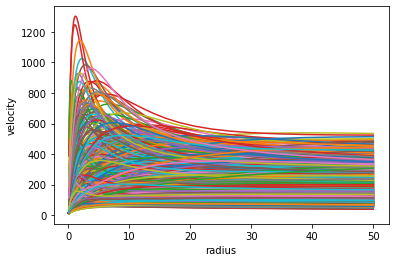

In [7]:
for v in cm.vc: plt.plot(cm.rad, v)
plt.xlabel('radius')
plt.ylabel('velocity');

### Normalization and train/valid splitting

As always when dealing with neural networks, it is generally a good idea to normalize the dataset and to randomly shuffle it.

In [258]:
def datanorm(x):  return (x-x.mean())/x.std(), x.mean(), x.std()
def datascale(x, m, s): return x*s+m

idshuff = torch.randperm(nsamp)
xdata = tensor(cm.vc, dtype=torch.float)[idshuff,:]
xdata, xmean, xstd = datanorm(xdata)

I also split the dataset into training and validation sets.

In [259]:
fval = 0.20
xtrain = xdata[:int(nsamp*(1.0-fval))]
xvalid = xdata[int(nsamp*(1.0-fval)):]

## Adding noise

We now add noise to our rotation curves, since we want the neural network to learn to de-noise a noisy curve. To do this, we construct a simple **noise scheduler** which is a function that adds noise to our input dataset corresponding to an amount `a` $\in [0,1]$, where if `a=0` the curve is noise-free and if `a=1` the data is pure Gaussian noise.

The term scheduler refers to the arbitrary interpolating function that we choose between the two regimes `a=0` and `a=1`. For the sake of simplicity, here I chose a linear scheduler.

In [106]:
def add_noise(x, a):
    noise = torch.randn_like(x)
    if a.shape != torch.Size([]): a = a.view(-1, 1)
    return x*(1-a) + noise*a

We can see the effect of adding noise to a given rotation curve in the set of plots below, where I gradually increase `a`.

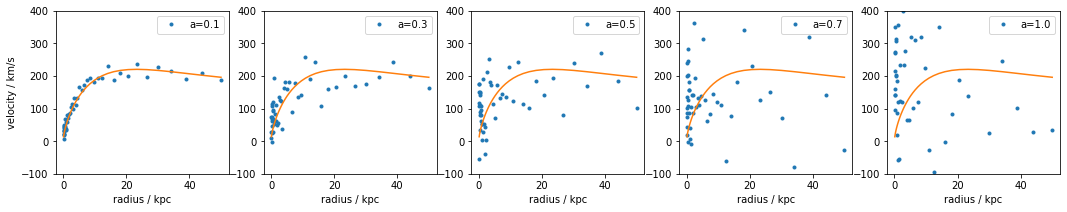

In [221]:
fig,ax=plt.subplots(figsize=(18,3),ncols=5)

def commons(ax, a):
    ax.plot(cm.rad, datascale(add_noise(xtrain[1],tensor(a)), xmean, xstd), '.', label='a=%1.1f' % a)
    ax.plot(cm.rad, datascale(xtrain[1], xmean, xstd))
    ax.set_xlabel('radius / kpc')
    ax.legend()
    ax.set_ylim(-100,400)

commons(ax[0], 0.1)
ax[0].set_ylabel('velocity / km/s')
commons(ax[1], 0.3)
commons(ax[2], 0.5)
commons(ax[3], 0.7)
commons(ax[4], 1.0)

## Model

Let's now set up the neural network that will learn to de-noise our rotation curves. This is done with a slightly modified autoencoder model, where I've added skip connections, just to be closer to the [U-Net](https://arxiv.org/abs/1505.04597) framework which is popular for diffusion models.

In [290]:
class AE_net(nn.Module):
    def __init__(self, ninp, **kwargs):
        super().__init__()
        self.encoder_layers = nn.ModuleList([
            nn.Linear(in_features=ninp, out_features=32),
            nn.Linear(in_features=32,   out_features=16),
            nn.Linear(in_features=16,   out_features=4)
        ])
        self.decoder_layers = nn.ModuleList([
            nn.Linear(in_features=4,    out_features=16),
            nn.Linear(in_features=16,   out_features=32),
            nn.Linear(in_features=32,   out_features=ninp)
        ])
        self.act = nn.SiLU()
        
            
    def forward(self, x):
        h = [] # skip connections
        
        for i, l in enumerate(self.encoder_layers):
            x = self.act(l(x))
            if i < 2: h.append(x) # store for skip connection, for all but final layer
              
        for i, l in enumerate(self.decoder_layers):
            if i > 0: x += h.pop() # get stored output for skip connection, for all but first layer
            x = self.act(l(x)) if i<2 else l(x) # final layer without activation
            
        return x

In [291]:
model = AE_net(len(cm.rad))

And now the training phase. Notice that we first add a random amount of noise to the rotation curve dataset and we pass these noisy curves to the autoencoder. This way, the model will learn to recognize the curves even when noise is added to them.

In [292]:
# Adam and MSE Loss
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(2001):
    
    # generate noise with random amount
    noise = torch.rand(xtrain.shape[0])
    
    # add noise to data
    x_noisy = add_noise(xtrain, noise)
    
    # prediction
    ymod = model.forward(x_noisy)
    
    # loss
    loss = loss_func(xtrain, ymod)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%100==0: print(epoch,"train L:%1.2e" % loss, "  valid L:%1.2e" % loss_func(xvalid, model.forward(xvalid)))

0 train L:1.00e+00   valid L:8.09e-01
100 train L:2.18e-01   valid L:5.60e-02
200 train L:1.44e-01   valid L:6.59e-02
300 train L:1.58e-01   valid L:4.65e-02
400 train L:1.56e-01   valid L:4.83e-02
500 train L:1.69e-01   valid L:2.14e-02
600 train L:1.51e-01   valid L:3.40e-02
700 train L:1.80e-01   valid L:3.54e-02
800 train L:1.86e-01   valid L:1.13e-01
900 train L:1.56e-01   valid L:4.06e-02
1000 train L:1.61e-01   valid L:2.52e-02
1100 train L:1.45e-01   valid L:2.53e-02
1200 train L:1.39e-01   valid L:2.08e-02
1300 train L:1.89e-01   valid L:2.77e-02
1400 train L:1.93e-01   valid L:8.97e-02
1500 train L:1.91e-01   valid L:2.62e-02
1600 train L:1.56e-01   valid L:2.71e-02
1700 train L:1.92e-01   valid L:2.74e-02
1800 train L:1.41e-01   valid L:2.08e-02
1900 train L:1.58e-01   valid L:3.61e-02
2000 train L:1.61e-01   valid L:2.42e-02


## Predictions

How well does the model predict the underlying rotation curves from their noisy version? It depends a lot from the noise amount. This is rather intuitive, since for low amount of noise we do expect the model to provide almost perfect predictions, whereas when the data is mostly comprised of noise than signal it is not surprising to see the model failing.

Let's see this in action with the following plot:

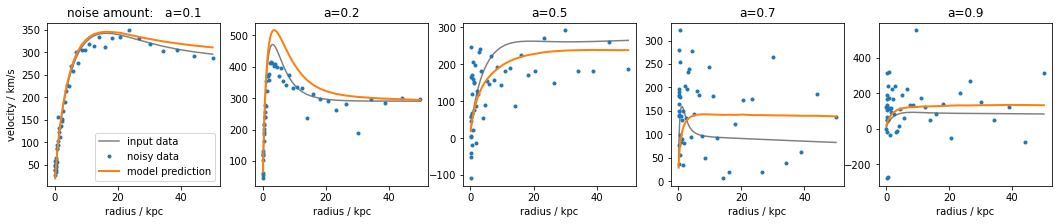

In [293]:
fig,ax=plt.subplots(figsize=(18,3),ncols=5)

x = xtrain[:5]
noise = tensor([0.1, 0.2, 0.5, 0.7, 0.9])
x_noisy = add_noise(x, noise)

with torch.no_grad():
    ymod = model(x_noisy).detach()

for i, xi in enumerate(x):
    ax[i].plot(cm.rad, datascale(xi, xmean, xstd), c='grey', label='input data')
    ax[i].plot(cm.rad, datascale(x_noisy[i], xmean, xstd), '.', label='noisy data')
    ax[i].plot(cm.rad, datascale(ymod[i], xmean, xstd), '-', lw=2, label='model prediction')
    ax[i].set_xlabel('radius / kpc')
    ax[i].set_title('a=%1.1f' % noise[i])
    if i == 0:
        ax[i].set_ylabel('velocity / km/s');
        ax[i].legend(loc='lower right')
        ax[i].set_title('noise amount:   a=%1.1f' % noise[i])
        

These results tell us that the model has successfully learned how to denoise high signal-to-noise rotation curves, i.e. data whose noise amount is fairly low, and that it struggels to capture the details of the curve at low signal-to-noise.

Of course, the autoencoder model that I used is quite simple and it could be further improved by making the model more sophisticated and the noise scheduler more efficient.

## Sampling

Finally, let's have a look at how we can use the model that I've just trained to generate new rotation curve data starting from random noise. We could, in principle, simply just feed some random noise into the model since it will give us a rotation curve as output. However, we saw before that the model becomes quite unreliable when the noise is dominant over the signal. So, how do we deal with this?

A smart, but simple, solution is to borrow from the way a diffusion differential equation is usually solved, that is applying the denoising iteratively in many steps, instead of all in one step. The idea is to start from random, apply just a small step of the denoising network, then take this output and apply another small denoising step to it until we have fully denoised the dataset. In this way, the denoising is done gradually, which allows for complex features to arise in the rotation curve, instead of always just predicting an average curve.

Let's apply 30 steps of denoising to 5 initial completely random datasets.

In [311]:
nsteps = 31
x_ini = torch.randn_like(x)
inputs  = []
outputs = []

for i in range(nsteps):
    with torch.no_grad():
        ymod = model(x_ini)
        
    if i%10==0:
        inputs.append(x_ini)
        outputs.append(ymod) 
        
    mix_factor = 1/(nsteps - i)                    # how much denoising we apply
    x_ini = x_ini*(1-mix_factor) + ymod*mix_factor # mix noisy input with model prediction
    
inputs  = torch.stack(inputs)
outputs = torch.stack(outputs)

Let's now plot a few of these *timesteps* for the 5 noise inputs:

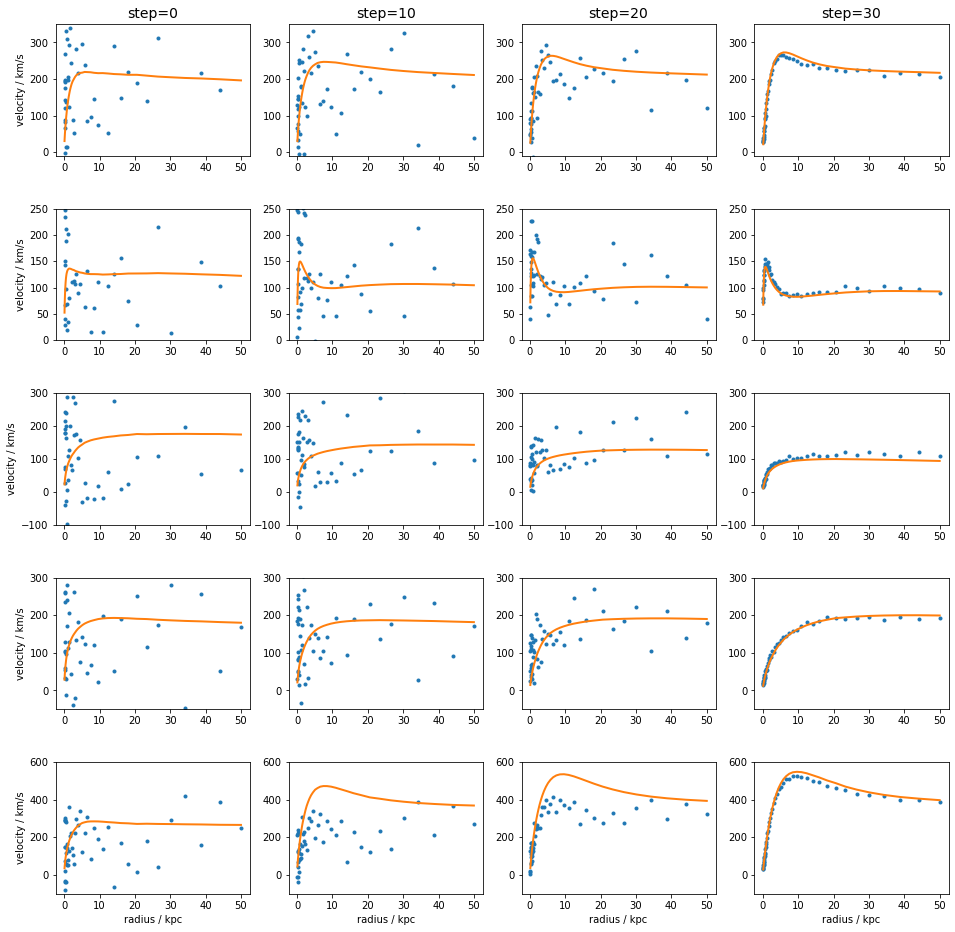

In [342]:
fig, ax = plt.subplots(figsize=(16,16), nrows=inputs.shape[1], ncols=inputs.shape[0], gridspec_kw={'hspace':0.4})

for i in range(inputs.shape[1]):
    for j in range(inputs.shape[0]):
        ax[i,j].plot(cm.rad, datascale(inputs[j,i], xmean, xstd), '.')
        ax[i,j].plot(cm.rad, datascale(outputs[j,i], xmean, xstd), '-', lw=2)
        
        if i == 0: ax[i,j].set_ylim(-10, 350)
        if i == 1: ax[i,j].set_ylim(0, 250)
        if i == 2: ax[i,j].set_ylim(-100, 300)
        if i == 3: ax[i,j].set_ylim(-50, 300)
        if i == 4: ax[i,j].set_ylim(-100, 600)
        
        if j == 0: ax[i,j].set_ylabel('velocity / km/s')
        if i == inputs.shape[1]-1: ax[i,j].set_xlabel('radius / kpc')
        if i == 0: ax[i,j].set_title('step=%d' % (j*10), fontsize=14)

As we can see, with this procedure the model is able to generate some new rotation curves that have significantly different shapes starting from full random noise! This happens since after the autoencoder has been trained to denoise a real rotation curve database, the slow denoising pipeline based on small *timesteps* that we created allows the model to enhance some peculiar -- and non average -- feature of the curve that it has inferred by chance from random noise. We observe the model to slowly convince itself that some accumulation of points that happens by chance actually hides some signal, which is cleaned and enhanced at each timestep.

Next we will see **how to guide** the model to see some particular feature in the random noise that we want in our rotation curve output.